The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


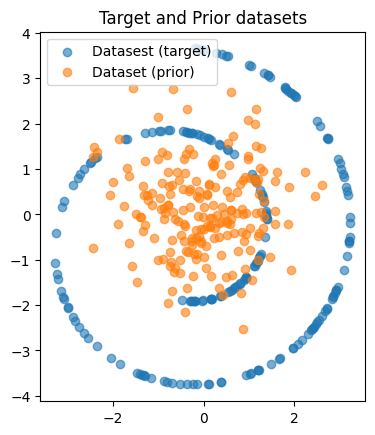

In [144]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=1000)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=1000)

Ntest = 200
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and Prior datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (prior)'])

In [140]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 256), nn.ReLU(),
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,2)
        )
    def forward(self, t, x):
        if t.ndim == 0:
            t = torch.atleast_2d(t)
        t = t.broadcast_to((x.shape[0],1))
        xt = torch.cat((t,x), -1)
        return self.model(xt)

def otflow_loss_fn(t, x0, x1, v_model):
    sigma_min = 1e-4
    t = torch.atleast_1d(t).unsqueeze(1)
    psi = (1 - t) * x1 + (1 - (1 - sigma_min) * (1 - t)) * x0
    u = (1 - sigma_min) * x0 - x1   
    return torch.square(v_model(t, psi) - u).mean()

def train(model, opt, loss_fn, n_iters, dataset, bsize=256):
    pbar = tqdm(range(n_iters), desc='loss: -')
    N1 = len(dataset)
    for i in pbar:
        t = torch.rand(bsize)
        x1 = dataset[torch.randint(N1, tuple([bsize]))]
        x0 = torch.randn_like(x1)
                
        loss = loss_fn(t, x0, x1, model)
                
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 500 == 0:
            pbar.set_description("Loss: {:.3f}".format(loss.item()))

                
v_model = MLP()
v_opt   = torch.optim.Adam(v_model.parameters(), lr=1e-5)
train(v_model, v_opt, otflow_loss_fn, 10000, target_ds)

Loss: 2.864: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 950.72it/s]


In [141]:
from torchdiffeq import odeint

plot_Ntest = 200
x0 = prior_ds[0:plot_Ntest]
t = torch.linspace(0,1,1000).flip((0))

print(prior_samples.shape)

with torch.no_grad():
    x_hist = odeint(v_model, x0, t)
    out = x_hist[-1]

# x_hist = list(range(plot_Ntest))

torch.Size([200, 2])


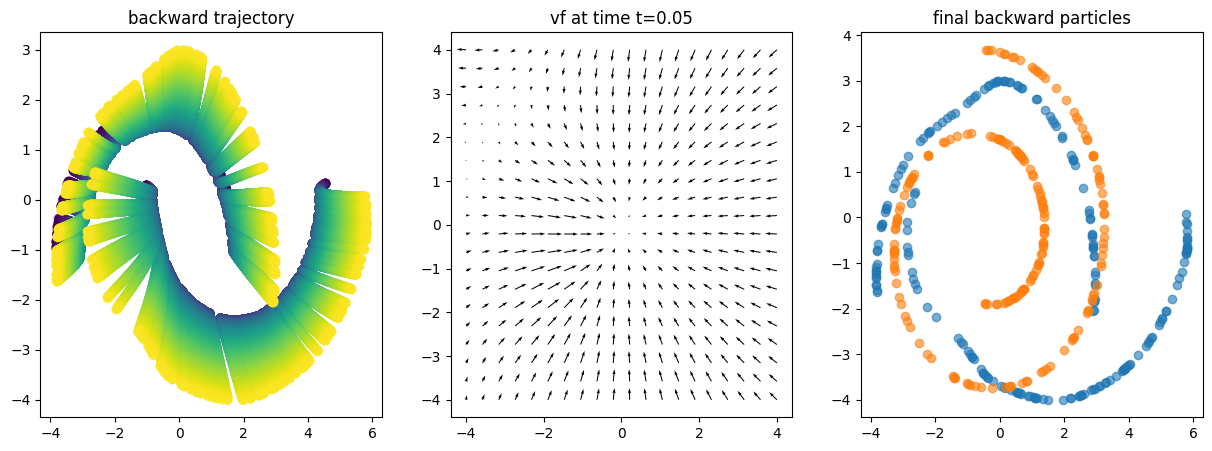

In [142]:
cmap = plt.get_cmap('viridis')


x_hist = x_hist.flip([0])
fig = plt.figure(figsize=(15, 5), dpi=100)
ax = fig.add_subplot(1, 3, 1)
t_arr = np.linspace(0, 1, 999)

for k, tt in enumerate(t_arr):
    outk = x_hist[-(k+1)-1]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
    
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "backward trajectory"
ax.set_title(strtitle)

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
# fig = plt.figure()
t0 = 0.05
x = np.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)

t_tensor = torch.tensor(t0)
x_tensor = torch.tensor(x).float()

with torch.no_grad():
    out = v_model(t_tensor, x_tensor)

u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 3, 2)
ax.quiver(xx, yy, u, v)
ax.set_aspect('auto', adjustable='box')
strtitle = f"vf at time t={t0}"
ax.set_title(strtitle)

out_true = target_ds[range(0, plot_Ntest)]
# fig = plt.figure()
ax = fig.add_subplot(1, 3, 3)
ax.scatter(x_hist[0, :, 0], x_hist[0, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "final backward particles"
ax.set_title(strtitle)
plt.savefig("./task1_output.jpg")